# Import libraries

In [1]:
!nvidia-smi

Fri Mar 29 01:46:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import torch

from torch.utils.data import Dataset
import torch
from transformers import AutoTokenizer

import pytorch_lightning as pl
from torch.utils.data import DataLoader

# Data cleaning

In [4]:
data = pd.read_csv("train.csv")
data.head()

,review,Improvement Suggestions,Questions and Answers,Experience Sharing,Technical Feedback,Support Request,Community Interaction,Course Comparison,Related Course Suggestions,not_praise
0,Thank you very much Prof. Scott Klemmer and ot...,0.0,0,1,0,0,1.0,0,0,0
1,It could be much better. The experience is old...,1.0,0,0,1,0,1.0,0,0,1
2,very interesting,0.0,0,0,0,0,0.0,0,0,1
3,Much more useful than the first course. It was...,0.0,0,1,0,0,0.0,0,0,0
4,This course was very nicely done. Dr Ngs video...,1.0,0,0,0,0,0.0,0,0,0


In [5]:
data.shape

(7387, 10)

<Axes: >

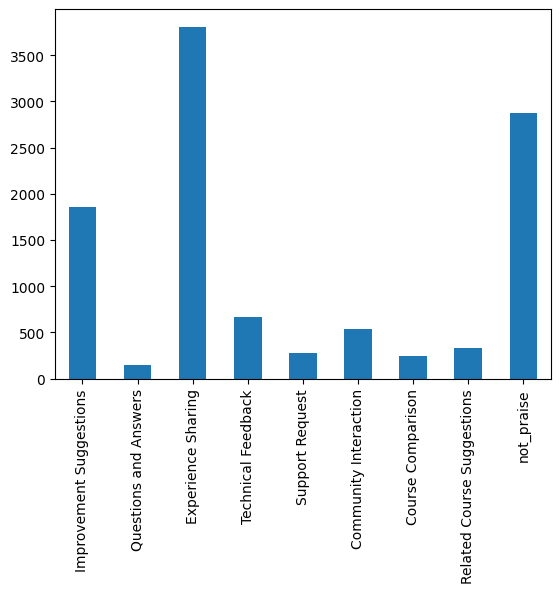

In [7]:
attributes = list(data.columns)[1:]
values_count = data[attributes].sum()
values_count.plot(kind='bar')

# Dataset

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=2024, test_size=0.1, shuffle=True)

In [ ]:
train.to_csv("train.csv")
test.to_csv("val.csv")

In [ ]:
print(f"Train shape: {train.shape}")
print(f"Val shape: {test.shape}")

Train shape: (10472, 10)
Val shape: (1164, 10)


**Dataset class**

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [70]:
class ReviewDataset(Dataset):

    def __init__(self, data_path, tokenizer, attributes, max_token_len=256):
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        # self.sample = sample
        self._prepare_data()

    def _prepare_data(self):
        data = pd.read_csv(self.data_path)
        # data['Praise'] = np.where(data['Praise'] == 1, 0, 1)
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data.iloc[index]
        review = str(item.review)
        attributes = torch.FloatTensor(item[self.attributes])
        tokens = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=self.max_token_len,
            return_attention_mask=True
        )

        return {
            'input_ids': tokens.input_ids.flatten(),
            'attention_mask': tokens.attention_mask.flatten(),
            'labels': attributes
        }

In [71]:
import torch
from transformers import AutoTokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
review_ds = ReviewDataset("train.csv", tokenizer, attributes=attributes)

In [72]:
review_val_ds = ReviewDataset("test.csv", tokenizer, attributes=attributes)

In [73]:
review_ds.__getitem__(100)

{'input_ids': tensor([    0,   133,   768,  1383,    21,  5145,     6, 10675,     8,  1552,
          1591,   602,    19,  7094,    13, 29316,   293,     4, 19324, 32851,
          3435,     4,  6323,     9,     5, 21350,  1552,   304,     9,   371,
           537,  2975,     8,  7656,    14,   222,  5043,    25,  5291,    50,
            32,   117,  1181,  2800,     4, 23029,   254, 32178,    21,   182,
          2129,     4,    85,  5705,  2551,   521,   222,    45,  1166, 18219,
             6,   160,  4507,   352, 32178,     4,   497,   498,  1450,   222,
            45,   914,     5,  4391,     6,   215,    25,  2579,   173,     6,
            50,   205,   633,     6,   150,  1311,   129,   155,  2690,     4,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [74]:
class ReviewDataModule(pl.LightningDataModule):

    def __init__(self, train_path, val_path, attributes, batch_size=16, max_token_length=128, model_name='roberta-base'):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def setup(self, stage=None):
        if stage in (None, "fit"):
            self.train_dataset = ReviewDataset(
                self.train_path,
                attributes=self.attributes,
                tokenizer=self.tokenizer
            )
            self.val_dataset = ReviewDataset(
                self.val_path,
                attributes=self.attributes,
                tokenizer=self.tokenizer
            )
        elif stage == 'predict':
            self.val_dataset = ReviewDataset(
                self.val_path,
                attributes=self.attributes,
                tokenizer=self.tokenizer
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=2,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=2,
            shuffle=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=4,
            shuffle=False
        )

In [75]:
review_data_module = ReviewDataModule('train.csv', 'test.csv', attributes=attributes)

In [76]:
review_data_module.setup()

In [77]:
review_data_module.train_dataloader()

# Model

In [23]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [24]:
class ReviewClassifier(pl.LightningModule):

    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
        self.dropout = nn.Dropout()

    def forward(self, input_ids, attention_mask, labels=None):
        # roberta layer
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        # final logits
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
        return loss, logits

    def training_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        self.log("train loss ", loss, prog_bar = True, logger=True)
        return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

    def validation_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        self.log("validation loss ", loss, prog_bar = True, logger=True)
        return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        return outputs

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = self.config['train_size']/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

In [79]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 128,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'train_size': len(review_data_module.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 10
}

model = ReviewClassifier(config)

In [27]:
# datamodule
review_data_module = ReviewDataModule("train.csv", "test.csv", attributes=attributes, batch_size=config['batch_size'])
review_data_module.setup()

In [28]:
model = ReviewClassifier(config)

In [80]:
trainer = pl.Trainer(max_epochs=config['n_epochs'], accelerator="gpu", num_sanity_val_steps=50)
trainer.fit(model, review_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_model | RobertaModel      | 82.1 M
1 | hidden           | Linear            | 590 K 
2 | classifier       | Linear 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
from transformers import PreTrainedModel
from torch import nn


class MyModel(PreTrainedModel):
    config_class = ModelConfig

    def __init__(self, config):
        super().__init__(config)
        self.model = net

    def forward(self, tensor):
        return self.model(tensor)

# Evaluation of the model

In [81]:
# method to convert list of comments into predictions for each comment
def classify_review(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [82]:
predictions = classify_review(model, review_data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
val_data = pd.read_csv('test.csv') # .drop(columns=['Unnamed: 0'])
# print(val_data.columns)
# val_data['Praise'] = np.where(val_data['Praise'] == 1, 0, 1)
true_labels = np.array(val_data[attributes])

In [53]:
val_ds = ReviewDataset('test.csv', tokenizer, attributes)
val_dataloader = DataLoader(
            val_ds,
            batch_size=64,
            shuffle=False
        )

In [83]:
predictions = trainer.predict(model, val_dataloader)
flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [88]:
flattened_predictions

array([[0.39355797, 0.01334746, 0.02391698, ..., 0.02537882, 0.02274585,
        0.81306124],
       [0.01173978, 0.01400621, 0.97367674, ..., 0.01235014, 0.02053417,
        0.0149267 ],
       [0.01623148, 0.01305532, 0.98094016, ..., 0.01475889, 0.0189394 ,
        0.0208089 ],
       ...,
       [0.00605694, 0.00725257, 0.87192035, ..., 0.007176  , 0.0111548 ,
        0.19422685],
       [0.03307352, 0.01149657, 0.18953075, ..., 0.02272904, 0.02475624,
        0.94413847],
       [0.00801655, 0.01647058, 0.9836236 , ..., 0.01479754, 0.03056198,
        0.01323616]], dtype=float32)

Text(0.5, 1.0, 'RoBERTa Trained on Review Datatset - AUC ROC')

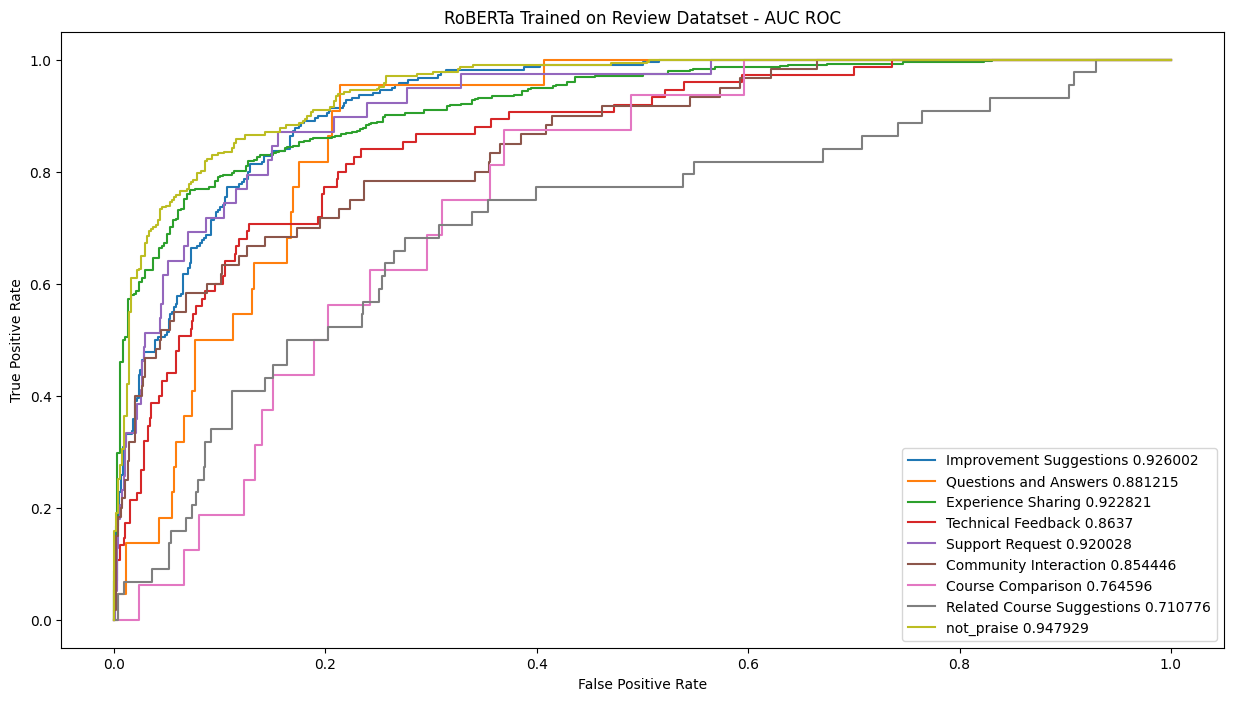

In [84]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
threshold = 0.5
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), flattened_predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), flattened_predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on Review Datatset - AUC ROC')